In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install --upgrade --force-reinstall --no-deps albumentations
!pip install pydicom

In [ ]:
import os
os.environ['KAGGLE_USERNAME']="NAME"
os.environ['KAGGLE_KEY']="KEY"

In [ ]:
!nvidia-smi

Thu Aug 27 12:30:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Necessary imports
!kaggle competitions download -c osic-pulmonary-fibrosis-progression
!unzip osic-pulmonary-fibrosis-progression.zip -d osic-pulmonary-fibrosis-progression
!rm -rf osic-pulmonary-fibrosis-progression.zip

!kaggle datasets download -d vgarshin/efficientnet
!unzip efficientnet.zip -d efficientnet
!rm -rf efficientnet.zip

!kaggle datasets download -d vgarshin/kerasapplications
!unzip kerasapplications.zip -d kerasapplications
!rm -rf kerasapplications.zip

In [ ]:
!pip install ./kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ./efficientnet/efficientnet-1.1.0/ -f ./ --no-index

In [ ]:
import os
import cv2
import pydicom
import random
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm 
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, Input, BatchNormalization, 
    Concatenate, Add, Conv2D, AveragePooling2D, LeakyReLU, GlobalMaxPooling2D, GaussianNoise)
from tensorflow.keras import Model
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
import tensorflow.keras.applications as tfa
import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns
from keras.callbacks import CSVLogger
import albumentations as Alb

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything()

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [ ]:
EPOCHS = 50
BATCH_SIZE = 4
NFOLD = 5
LR = 0.0005
SAVE_BEST = True
MODEL_CLASS = 'b5'

In [ ]:
train = pd.read_csv('./osic-pulmonary-fibrosis-progression/train.csv') 

In [ ]:
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0] == 'Male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [ ]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [ ]:
def get_train_transforms():
    return Alb.Compose(
        [
            #Alb.RandomSizedCrop(min_max_height=(200, 200), height=512, width=512, p=1),
            Alb.HorizontalFlip(p=0.5),
            Alb.VerticalFlip(p=0.5),
            Alb.RandomRotate90(p=0.5),
            Alb.GaussianBlur(p=0.5),
            Alb.CoarseDropout(max_holes=10, max_height=32, max_width=32, fill_value=0, p=0.5),
            Alb.Rotate(limit=90, interpolation=1, border_mode=0, p=0.75)
        ], p=1.0
    )

def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize((d.pixel_array - d.RescaleIntercept) / (d.RescaleSlope * 1000), (512, 512))

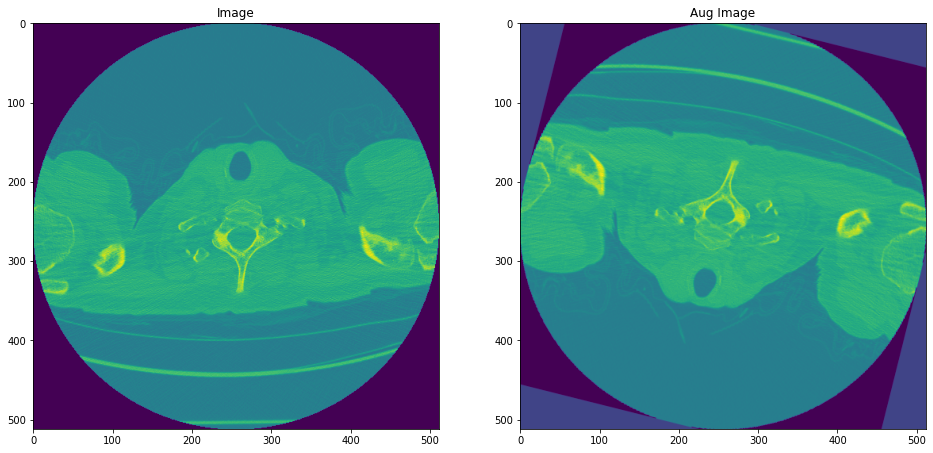

In [ ]:
def call_me():    
    fig, ax = plt.subplots(1, 2, figsize=(16, 16))
    image = get_img('/content/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/1.dcm')
    ax[0].set_title('Image')
    ax[0].imshow((image));
    transforms = get_train_transforms()
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    #aug_img = tf.cast(aug_img/255.0, tf.float32)
    ax[1].set_title('Aug Image')
    ax[1].imshow((aug_img));

call_me()

In [ ]:
class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, transforms= None, test=False, batch_size=BATCH_SIZE):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        self.test = test
        self.transforms = transforms
        self.len = 1000 #sum([len(files) for r, d, files in os.walk("./osic-pulmonary-fibrosis-progression/train")])
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'./osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        #return 1000
        return self.len
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)

        if not self.test:
            for k in keys:
                i = np.random.choice(self.train_data[k], size=1)[0]
                image = get_img(f'./osic-pulmonary-fibrosis-progression/train/{k}/{i}')

                data = {"image":image}
                aug_data = self.transforms(**data)
                aug_img = aug_data["image"]
                #aug_img = tf.cast(aug_img/255.0, tf.float32)  # Why so slowwww?
                
                x.append(aug_img)
                a.append(self.a[k])
                tab.append(self.tab[k])

                """for ite,(key, aug) in enumerate(augs.items()):
                    if aug is not None:
                        image = aug(image=image)['image']
                        x.append(image)
                        a.append(self.a[k])
                        tab.append(self.tab[k])"""
        else:
            for k in keys:
                try:
                    i = np.random.choice(self.train_data[k], size=1)[0]
                    img = get_img(f'./osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                    x.append(img)
                    a.append(self.a[k])
                    tab.append(self.tab[k])
                except:
                    print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

(512, 512, 1)


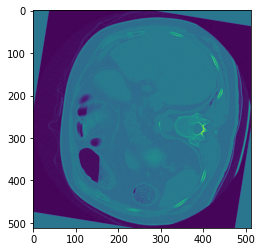

In [ ]:
def call_me_again(P):
    kf = KFold(n_splits=NFOLD)
    P = np.array(P)
    for (tr_idx, val_idx) in kf.split(P):
        dataset = IGenerator(keys=P[tr_idx],
                    a = A, 
                    tab = TAB,
                    transforms=get_train_transforms())
        data, _ = dataset[0]
        img = data[0][0]
        print(img.shape)
        plt.imshow((tf.squeeze(img)));
        break

call_me_again(P)

In [ ]:
def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalMaxPooling2D()(x)
    inp2 = Input(shape=(4,))
    x2 = Dense(80, activation="relu")(inp2)
    x2 = GaussianNoise(0.1)(x2)
    x2 = Dense(40, activation="relu")(x2)
    x2 = Dropout(0.5)(x2)
    x2 = Dense(20, activation="relu")(x2)
    x = Concatenate()([x, x2]) 
    x = Dropout(0.25)(x) 
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    return model

# Training

In [ ]:
kf = KFold(n_splits=NFOLD)
!mkdir CKP
P = np.array(P)
subs = []
folds_history = []
er = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

rlp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=5, 
    verbose=1, 
    min_lr=1e-8
)

csv_logger = CSVLogger('./CKP/log.csv', append=True, separator=',')

In [ ]:
%%time
for fold, (tr_idx, val_idx) in enumerate(kf.split(P)):
    print('#####################')
    print('####### Fold %i ######'%fold)

    cpt = tf.keras.callbacks.ModelCheckpoint(
        filepath='./CKP/fold-%i.h5'%fold,
        monitor='val_loss', 
        verbose=0, 
        save_best_only=SAVE_BEST,
        mode='auto'
    )

    model = build_model(model_class=MODEL_CLASS)
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=LR), loss='mae') 
    history = model.fit_generator(IGenerator(keys=P[tr_idx], 
                                   a = A, 
                                   tab = TAB,
                                   transforms=get_train_transforms()), 
                        steps_per_epoch = 16,
                        validation_data=IGenerator(keys=P[val_idx], 
                                   a = A, 
                                   tab = TAB,
                                   test = True),
                        #validation_steps = 16, 
                        callbacks = [cpt, rlp, csv_logger], 
                        epochs=EPOCHS)
    folds_history.append(history.history)
    print('#####################')
    #break

print('Training done!')

#####################
####### Fold 0 ######
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
16/16 [==============================] - 99s 6s/step - loss: 5.8970 - val_loss: 6.8348
Epoch 2/50
16/16 [==============================] - 96s 6s/step - loss: 6.4346 - val_loss: 6.6401
Epoch 3/50
16/16 [==============================] - 97s 6s/step - loss: 5.6473 - val_loss: 6.2720
Epoch 4/50
16/16 [==============================] - 97s 6s/step - loss: 5.7123 - val_loss: 6.1335
Epoch 5/50
16/16 [==============================] - 95s 6s/step - loss: 5.0376 - val_loss: 6.2046
Epoch 6/50
16/16 [==============================] - 94s 6s/step - loss: 6.9376 - val_loss: 6.6013
Epoch 7/50
16/16 [==============================] - 95s 6s/step - loss: 5.5629 - val_loss: 6.2967
Epoch 8/50
16/16 [==============================] - 94s 6s/step - loss: 5.7779 - val_loss: 6.1768
Epoch 9/50
16/16 [==============================] - 97s 6s/step - loss: 5.4434 - val_loss: 6.042

In [ ]:
if SAVE_BEST:
    mean_val_loss = np.mean([np.min(h['val_loss']) for h in folds_history])
else:
    mean_val_loss = np.mean([h['val_loss'][-1] for h in folds_history])
print('mean CV MAE: ' + str(mean_val_loss))

mean CV MAE: 4.921109676361084


In [ ]:
hist = pd.read_csv('/content/CKP/log.csv', sep = ',') 
hist

,epoch,loss,lr,val_loss
0,0,5.299433,0.000500,6.849020
1,1,5.862049,0.000500,6.859978
2,2,4.382687,0.000500,6.976542
3,3,5.411164,0.000500,7.006300
4,4,4.815041,0.000500,7.155955
...,...,...,...,...
85,45,4.539553,0.000031,6.501921
86,46,4.965157,0.000031,7.475377
87,47,3.907591,0.000031,7.921459
88,48,3.909472,0.000016,8.720813
